# Reconocimiento de comandos de voz con torchaudio
******************************************

In [ ]:
!pip install pydub
!pip install torchaudio

     |████████████████████████████████| 1.9 MB 8.3 MB/s 


In [ ]:
%matplotlib inline

Este tutorial le mostrará cómo formatear correctamente un conjunto de datos de audio y luego entrenar / probar una red de clasificador de audio en el conjunto de datos.

Colab tiene la opción de GPU disponible. En las pestañas del menú, seleccione "Tiempo de ejecución" y luego "Cambiar tipo de tiempo de ejecución". En la ventana emergente que aparece a continuación, puede elegir GPU. Después del cambio, su tiempo de ejecución debería reiniciarse automáticamente (lo que significa que la información de las celdas ejecutadas desaparece).

Primero, importemos los paquetes de Pytorch comunes, como torchaudio.




In [ ]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import numpy as np

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm
import librosa
import librosa.display

Verifiquemos si hay una GPU CUDA disponible y seleccionemos nuestro dispositivo. Ejecutar la red en una GPU disminuirá en gran medida el tiempo de ejecución de entrenamiento / prueba.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Importar el conjunto de datos
---------------------

Usamos torchaudio para descargar y representar el conjunto de datos. Aquí usamos [SpeechCommands](https://arxiv.org/abs/1804.03209), que es un conjunto de datos de 35 comandos hablados por diferentes personas. El conjunto de datos ` SPEECHCOMMANDS` forma parte de `torch.utils.data.Dataset`. En este conjunto de datos, todos los archivos de audio tienen una duración de aproximadamente 1 segundo (y por lo tanto, aproximadamente 16000 frames de tiempo).

Los pasos reales de carga y formateo ocurren cuando se accede a un datapoint, y torchaudio se encarga de convertir los archivos de audio a tensores. Si uno quiere cargar un archivo de audio directamente en su lugar, se puede utilizar `torchaudio.load()`. Esto devuelve una tupla que contiene el tensor recién creado junto con la frecuencia de muestreo del archivo de audio (16 kHz para SpeechCommands).

Volviendo al conjunto de datos, aquí creamos una subclase que lo divide en subconjuntos estándar de entrenamiento, validación y prueba.




In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Cree una división de entrenamiento y prueba de los datos. No usamos validación en este tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

Un datapoint en el conjunto de datos SPEECHCOMMANDS es una tupla hecha de una forma de onda (la señal de audio), la frecuencia de muestreo, la expresión (etiqueta), la identificación del hablante, el número de la expresión.




Forma de la onda: torch.Size([1, 16000])
Sample rate de la onda: 16000


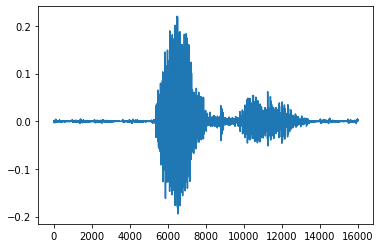

In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[66]

print("Forma de la onda: {}".format(waveform.size()))
print("Sample rate de la onda: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Forma espectrograma: torch.Size([1, 128, 81])


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


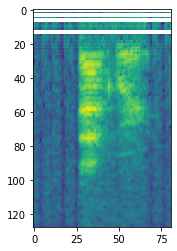

In [ ]:
specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Forma espectrograma: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy())

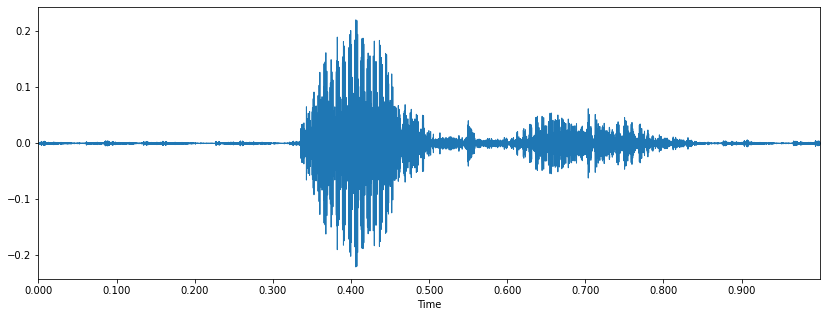

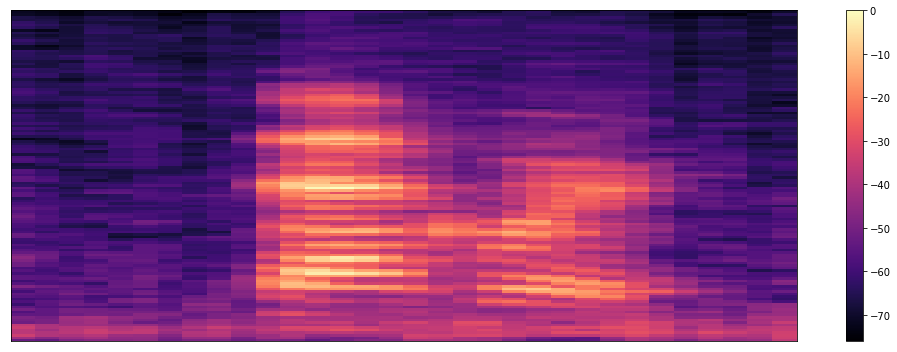

In [ ]:
x, sr = waveform.t().numpy().squeeze(1), sample_rate

plt.figure(figsize=(14, 5))



librosa.display.waveplot(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
#librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
Xdb.shape

S = librosa.feature.melspectrogram(x, sr=sample_rate, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
MFCC = librosa.feature.mfcc(S=log_S, n_mfcc=23)
delta2_mfcc = librosa.feature.delta(MFCC, order=2)

#MFCC = librosa.feature.mfcc(y=x, sr=sample_rate,n_mfcc=23,dct_type=2)
librosa.display.specshow(log_S)
#print(np.max(MFCC),np.min(MFCC))
#MFCC = (MFCC+200)/500
#print(np.max(MFCC),np.min(MFCC))
plt.colorbar()
plt.tight_layout()

Busquemos la lista de etiquetas disponibles en el conjunto de datos.




In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

Las 35 etiquetas de audio son comandos que dicen los usuarios. Los primeros archivos son personas que dicen "backward".




In [ ]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

El último archivo es alguien que dice "zero".




In [ ]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatear los datos
-------------------

Este es un buen lugar para aplicar transformaciones a los datos. Para la forma de onda, reducimos la resolución del audio para un procesamiento más rápido sin perder demasiado poder de clasificación.

No necesitamos aplicar otras transformaciones aquí. Sin embargo, es común que algunos conjuntos de datos tengan que reducir el número de canales (por ejemplo, de estéreo a mono) tomando la media a lo largo de la dimensión del canal o simplemente manteniendo solo uno de los canales. Dado que SpeechCommands usa un solo canal para audio, esto no es necesario aquí.




In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

Estamos codificando cada palabra usando su índice en la lista de etiquetas.




In [ ]:
def label_to_index(word):
    # Devuelve la posición de la palabra en las etiquetas
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Devuelve la palabra correspondiente al índice en las etiquetas
    # Esta es la inversa de label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


Para convertir una lista de datapoints formada por grabaciones de audio y enunciados en dos tensores por lotes para el modelo, implementamos una función de clasificación que es utilizada por PyTorch DataLoader que nos permite iterar sobre un conjunto de datos por lotes. Consulte la [documentación](https://pytorch.org/docs/stable/data.html#working-with-collate-fn) para obtener más información sobre cómo trabajar con una función de clasificación.

En la función de clasificación, también aplicamos el remuestreo y el texto codificación.




In [ ]:
def pad_sequence(batch):
    # Haga que todos los tensores de un lote tengan la misma longitud rellenando con ceros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # Una tupla de datos tiene la forma:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Reúna en listas y codifique etiquetas como índices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Agrupe la lista de tensores en un tensor por lotes
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets) 
    
    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Definir la red
------------------

Para este tutorial usaremos una red neuronal convolucional para procesar los datos de audio sin procesar. Por lo general, se aplican transformaciones más avanzadas a los datos de audio, sin embargo, las CNN se pueden usar para procesar con precisión los datos sin procesar.
La arquitectura específica se modela a partir de la arquitectura de red M5 descrita en [este paper](https://arxiv.org/pdf/1610.00087.pdf). Un aspecto importante de los modelos que procesan datos de audio sin procesar es el campo receptivo de los filtros de su primera capa. El primer filtro de nuestro modelo tiene una longitud de 80, por lo que cuando se procesa audio muestreado a 8 kHz, el campo receptivo es de alrededor de 10 ms (y a 4 kHz, alrededor de 20 ms). Este tamaño es similar a las aplicaciones de procesamiento de voz que a menudo utilizan campos receptivos que van desde 20 ms hasta 40 ms.



In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Número de parámetros: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

Usaremos la misma técnica de optimización utilizada en el artículo, un optimizador de Adam con una disminución de peso establecida en 0,0001. Al principio, entrenaremos con una tasa de aprendizaje de 0.01, pero usaremos un `scheduler` para disminuirlo a 0,001 durante el entrenamiento después de 20 épocas.




In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Ahora que tenemos una función de entrenamiento, necesitamos crear una para probar la precisión de las redes. Configuraremos el modelo en modo `eval()` y luego ejecutaremos la inferencia en el conjunto de datos de prueba. Llamar a `eval()` establece la variable de entrenamiento en todos los módulos de la red en falso. Ciertas capas, como la normalización de lotes y las capas de abandono, se comportan de manera diferente durante el entrenamiento, por lo que este paso es crucial para obtener resultados correctos.




In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # encontrar el índice de etiqueta más probable para cada elemento del lote
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finalmente, podemos entrenar y probar la red. Entrenaremos a la red
durante diez épocas, luego reduce la tasa de aprendizaje y entrena durante diez épocas más.
La red se probará después de cada época para ver cómo la precisión
varía durante el entrenamiento.



In [ ]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# La transformación debe vivir en el mismo dispositivo que el modelo y los datos.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/105829 (0%)]	Loss: 3.830327
Train Epoch: 1 [5120/105829 (5%)]	Loss: 3.125507
Train Epoch: 1 [10240/105829 (10%)]	Loss: 2.614277
Train Epoch: 1 [15360/105829 (14%)]	Loss: 2.302894
Train Epoch: 1 [20480/105829 (19%)]	Loss: 2.154182
Train Epoch: 1 [25600/105829 (24%)]	Loss: 1.983730
Train Epoch: 1 [30720/105829 (29%)]	Loss: 1.998342
Train Epoch: 1 [35840/105829 (34%)]	Loss: 1.800250
Train Epoch: 1 [40960/105829 (39%)]	Loss: 1.651220
Train Epoch: 1 [46080/105829 (43%)]	Loss: 1.516853
Train Epoch: 1 [51200/105829 (48%)]	Loss: 1.477048
Train Epoch: 1 [56320/105829 (53%)]	Loss: 1.539280
Train Epoch: 1 [61440/105829 (58%)]	Loss: 1.179756
Train Epoch: 1 [66560/105829 (63%)]	Loss: 1.465654
Train Epoch: 1 [71680/105829 (68%)]	Loss: 1.275938
Train Epoch: 1 [76800/105829 (72%)]	Loss: 1.338970
Train Epoch: 1 [81920/105829 (77%)]	Loss: 1.180194
Train Epoch: 1 [87040/105829 (82%)]	Loss: 1.116816
Train Epoch: 1 [92160/105829 (87%)]	Loss: 1.277471
Train Epoch: 1 [97280/105829 (92%)]	Lo

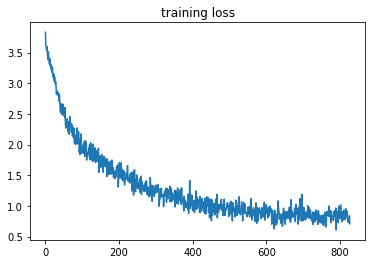

In [ ]:
# Let's plot the training loss versus the number of iteration.
plt.plot(losses);
plt.title("training loss");

La red debe tener una precisión superior al 65% en el conjunto de prueba después de 2 épocas y al 85% después de 21 épocas. Veamos las últimas palabras del conjunto de entrenamiento y veamos cómo le fue al modelo.




In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Esperado: {utterance}. Predicción: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Busquemos un ejemplo que no esté clasificado correctamente, si lo hay.




In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Esperado: {utterance}. Predicción: {output}.")
        break
else:
    print("Todos los ejemplos de este conjunto de datos se clasificaron correctamente!")
    print("En este caso, veamos el último data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Esperado: {utterance}. Predicción: {output}.")

Data point #1. Expected: right. Predicted: nine.


¡No dudes en probar con una de tus propias grabaciones de una de las etiquetas!
Por ejemplo, si usa Colab, diga "Go" mientras ejecuta la celda a continuación. Esto grabará un segundo de audio e intentará clasificarlo.




In [ ]:
from google.colab import output as colab_output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment


RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""


def record(seconds=1):
    display(ipd.Javascript(RECORD))
    print(f"La grabación comenzó durante {seconds} segundos.")
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Grabación terminada.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


waveform, sample_rate = record()
print(f"Predicción: {predict(waveform)}.")
ipd.Audio(waveform.numpy(), rate=sample_rate)

<IPython.core.display.Javascript object>

Recording started for 1 seconds.
Recording ended.
Predicted: two.


Conclusión
----------

En este tutorial, usamos torchaudio para cargar un conjunto de datos y volver a muestrear la señal. Luego hemos definido una red neuronal que entrenamos para
reconocer un comando dado. También existen otros métodos de preprocesamiento de datos, como encontrar los coeficientes cepstrales de frecuencia mel (MFCC),
que puede reducir el tamaño del conjunto de datos. Esta transformación también está disponible en torchaudio como `torchaudio.transforms.MFCC`.


